In [1]:
import tensorflow as tf
import numpy as np
import math
import csv
import random
from six.moves import xrange
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
with open('./csv/train.csv', newline='') as csvfile:
    csv_file_object = csv.reader(csvfile, dialect='excel')
    header = csv_file_object.__next__()
    
    data=[]                          # Create a variable called 'data'.
    for row in csv_file_object:      # Run through each row in the csv file,
        data.append(row)             # adding each row to the data variable
    data = np.array(data)            # Then convert from a list to an array

h1 = header[1:3]
h2 = header[4:8]
h3 = header[9]
h1.extend(h2)
h1.append(h3)
header = h1
data = data[0::, [1, 2, 4, 5, 6, 7, 9]]
data[ data[0::, 2] == 'female', 2] = 0
data[ data[0::, 2] == 'male', 2] = 1
data[ data[0::, 3] == '', 3] = 0

data = data.astype(np.float)

print(header)

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']


In [3]:
with open('./csv/test.csv', newline='') as csvfile:
    csv_file_object = csv.reader(csvfile, dialect='excel')
    header = csv_file_object.__next__()
    
    test=[]
    for row in csv_file_object:
        test.append(row)
    test = np.array(test)

ids = test[0::, 0]
test = test[0::, [1, 3, 4, 5, 6, 8]]
test[ test[0::, 1] == 'female', 1] = 0
test[ test[0::, 1] == 'male', 1] = 1
test[ test[0::, 2] == '', 2] = 0
test[ test[0::, 5] == '', 5] = 0

test = test.astype(float)

print(header)

['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [4]:
# 2.2 Define some constants.
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 2

# The MNIST images are always 28x28 pixels.
INPUT_SIZE = 6

# Batch size. Must be evenly dividable by dataset sizes.
BATCH_SIZE = 60
EVAL_BATCH_SIZE = 1

# Number of units in hidden layers.
HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 128

# Maximum number of training steps.
MAX_STEPS = 300000

# Directory to put the trained data.
TRAIN_DIR="/tmp/titanic"

In [5]:
# 2.4 Build inference graph.
def mnist_inference(inputs, hidden1_units, hidden2_units):
    """Build the MNIST model up to where it may be used for inference.
    Args:
        images: Images placeholder.
        hidden1_units: Size of the first hidden layer.
        hidden2_units: Size of the second hidden layer.
    Returns:
        logits: Output tensor with the computed logits.
    """
    # Hidden 1
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([INPUT_SIZE, hidden1_units],
                                stddev=1.0 / math.sqrt(float(INPUT_SIZE))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden1_units]),
                             name='biases')
        hidden1 = tf.nn.relu(tf.matmul(inputs, weights) + biases)
    # Hidden 2
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1_units, hidden2_units],
                                stddev=1.0 / math.sqrt(float(hidden1_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden2_units]),
                             name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
    # Linear
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2_units, NUM_CLASSES],
                                stddev=1.0 / math.sqrt(float(hidden2_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                             name='biases')
        logits = tf.matmul(hidden2, weights) + biases

    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "inference.pbtxt", as_text=True)
    return logits

In [6]:
# 2.5 Build training graph.
def mnist_training(logits, labels, learning_rate):
    """Build the training graph.

    Args:
        logits: Logits tensor, float - [BATCH_SIZE, NUM_CLASSES].
        labels: Labels tensor, int32 - [BATCH_SIZE], with values in the
          range [0, NUM_CLASSES).
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
        loss: The Op for calculating loss.
    """
    # Create an operation that calculates loss.
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Uncomment the following line to see what we have constructed.
#     tf.train.write_graph(tf.get_default_graph().as_graph_def(),
#                          "/tmp", "train.pbtxt", as_text=True)

    return train_op, loss

In [7]:
# 2.6 Build the complete graph for feeding inputs, training, and saving checkpoints.
mnist_graph = tf.Graph()
with mnist_graph.as_default():
    # Generate placeholders for the images and labels.
    inputs_placeholder = tf.placeholder(tf.float32)                                       
    labels_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection("inputs", inputs_placeholder)  # Remember this Op.
    tf.add_to_collection("labels", labels_placeholder)  # Remember this Op.

    # Build a Graph that computes predictions from the inference model.
    logits = mnist_inference(inputs_placeholder,
                             HIDDEN1_UNITS,
                             HIDDEN2_UNITS)
    tf.add_to_collection("logits", logits)  # Remember this Op.

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op, loss = mnist_training(logits, labels_placeholder, 0.01)

    # Add the variable initializer Op.
    init = tf.initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    
    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "complete.pbtxt", as_text=True)

Step 0: loss = 1.03
[ 1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.
  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.
  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.  0.]
Step 1000: loss = 0.50
Step 2000: loss = 0.71
Step 3000: loss = 0.51
Step 4000: loss = 0.56
Step 5000: loss = 0.41
Step 6000: loss = 0.59
Step 7000: loss = 0.38
Step 8000: loss = 0.56
Step 9000: loss = 0.44
Step 10000: loss = 0.43
Step 11000: loss = 0.33
Step 12000: loss = 0.45
Step 13000: loss = 0.31
Step 14000: loss = 0.44
Step 15000: loss = 0.33
Step 16000: loss = 0.32
Step 17000: loss = 0.46
Step 18000: loss = 0.47
Step 19000: loss = 0.31
Step 20000: loss = 0.41
Step 21000: loss = 0.54
Step 22000: loss = 0.31
Step 23000: loss = 0.30
Step 24000: loss = 0.55
Step 25000: loss = 0.36
Step 26000: loss = 0.35
Step 27000: loss = 0.34
Step 28000: loss = 0.29
Step 29000: loss = 0.26
Step 30000: loss = 0.39
Step 31000: loss = 0.20


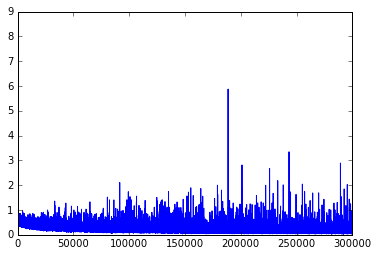

In [8]:
# 2.7 Run training for MAX_STEPS and save checkpoint at the end.
with tf.Session(graph=mnist_graph) as sess:
    # Run the Op to initialize the variables.
    sess.run(init)

    # Start the training loop.
    losses = []
    for step in xrange(MAX_STEPS):
        # Read a batch of images and labels.
#         if step == 0:
#             print(data)
        np.random.shuffle(data)
        batch = data[:BATCH_SIZE]
        inputs_feed = batch[0::, 1:]
        labels_feed = batch[0::, 0]
        
        if step == 100:
            print(labels_feed)

        # Run one step of the model.  The return values are the activations
        # from the `train_op` (which is discarded) and the `loss` Op.  To
        # inspect the values of your Ops or variables, you may include them
        # in the list passed to sess.run() and the value tensors will be
        # returned in the tuple from the call.
        _, loss_value = sess.run([train_op, loss],
                                 feed_dict={inputs_placeholder: inputs_feed, labels_placeholder: labels_feed})

        losses.append(loss_value)
        # Print out loss value.
        if step % 1000 == 0:
            print('Step %d: loss = %.2f' % (step, loss_value))

    # Write a checkpoint.
    checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)
    plt.plot(losses)

In [9]:
# 2.8 Run evaluation based on the saved checkpoint.
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-1999.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint-1999"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    inputs_placeholder = tf.get_collection("inputs")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    inputs_feed = test
    labels_feed = test[0::, 0].astype(np.int)

    prediction = sess.run(eval_op,
                          feed_dict={inputs_placeholder: inputs_feed,
                                     labels_placeholder: labels_feed})

In [11]:
with open('simple_nn.csv', 'w', newline='') as csvfile:
    csv_file_object = csv.writer(csvfile, dialect='excel')
    csv_file_object.writerow(["PassengerId", "Survived"])
    for i in xrange(ids.size):
        csv_file_object.writerow([ids[i], 1])